OSQP（Operator Splitting Quadratic Program）是一个高效、开源的二次规划求解器，特别适用于求解凸二次规划问题

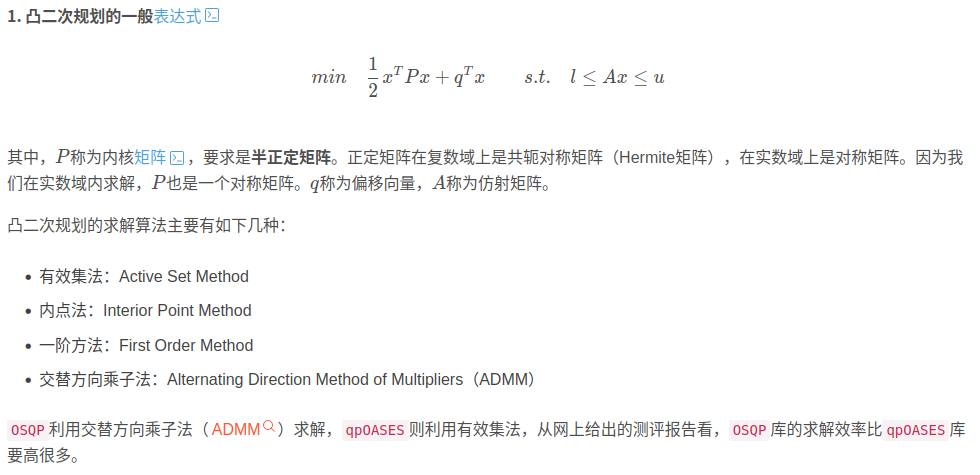

OSQP使用的是C语言  
OSQP-Eigen是C++   
以下是c语言版本的示例，首先构建标准问题  
$$min \quad \frac{1}{2}x^TPx+q^Tx \quad l \leq Ax \leq u $$

构建矩阵 P和 A（采用CSC稀疏矩阵格式），以及向量 q, l, u
$$x=\begin{bmatrix} x_1 \\ x_2 \end{bmatrix}$$
$$P=\begin{bmatrix} 4.0 & 1.0 \\ 1.0 & 2.0 \end{bmatrix}$$
$$q^T=\begin{bmatrix} 1.0 & 1.0 \end{bmatrix}$$
$$A=\begin{bmatrix} 1.0 & 1.0 \\ 1.0 & 0.0 \\0.0 & 1.0 \end{bmatrix}$$
$$u=\begin{bmatrix} 1.0 \\ 0.0 \\ 0.0  \end{bmatrix}$$
$$l=\begin{bmatrix} 1.0 \\ 0.7 \\ 0.7  \end{bmatrix}$$


csc_matrix（Compressed Sparse Column matrix，压缩稀疏列矩阵）是一种专门用于高效存储和处理稀疏矩阵（即矩阵中绝大部分元素为零）的数据结构。它以列优先的方式压缩存储非零元素，在科学计算、数据分析、机器学习以及工程优化（如OSQP求解器）中应用广泛  
<pre>csc_matrix(m,n,nnz,x,i,p)
第1个参数 (m)​      OSQPInt       矩阵的行数。
	
第2个参数 (n)​      OSQPInt       矩阵的列数。
	
第3个参数 (nnz)​    OSQPInt       矩阵中非零元素的最大数量（或实际数量）。
	
第4个参数 (x)​      OSQPFloat     一维数组，存储所有非零元素的值。按列的顺序排列。
	
第5个参数 (i)​      OSQPInt       一维数组，存储每个非零元素对应的行索引（从0开始）。
	
第6个参数 (p)      ​OSQPInt       一维数组，称为列指针。其长度为 n+1。
                              p[j]表示第 j列第一个非零元在 x和 i数组中的起始索引。p[n]等于 nnz。

返回值是一个指向OSQPCscMatrix结构体的指针

In [ ]:
#include <osqp/osqp.h>
#include <stdio.h>
#include <stdlib.h>

OSQPInt n = 2;
OSQPInt m = 3;

OSQPFloat P_x[3] = {4.0, 1.0, 2.0};
OSQPInt P_i[3] = {0, 0, 1};
OSQPInt P_p[3] = {0, 1, 3};
OSQPInt P_nnz = 3;

OSQPFloat A_x[4] = {1.0, 1.0, 1.0, 1.0};
OSQPInt A_i[4] = {0, 1, 0, 2};
OSQPInt A_p[3] = {0, 2, 4};
OSQPInt A_nnz = 4;

// 使用 OSQPCscMatrix_new
OSQPCscMatrix* P = OSQPCscMatrix_new(n, n, P_nnz, P_x, P_i, P_p);
OSQPCscMatrix* A = OSQPCscMatrix_new(m, n, A_nnz, A_x, A_i, A_p);

In [ ]:
// q向量 (线性项)
OSQPFloat q[2] = {1.0, 1.0};
// 约束边界
OSQPFloat l[3] = {1.0, 0.0, 0.0};
OSQPFloat u[3] = {1.0, 0.7, 0.7};

// 4. 声明求解器和工作变量
OSQPSolver* solver;
OSQPInt exitflag;

设置求解参数 (OSQPSettings)，可以创建设置对象并配置参数，或直接使用默认设置

In [ ]:
// 5. 配置求解器设置
// 设置配置
OSQPSettings* settings = (OSQPSettings*)malloc(sizeof(OSQPSettings));
if (settings) {
    osqp_set_default_settings(settings);
}

// 设置问题并求解
exitflag = osqp_setup(&solver, P, q, A, l, u, m, n, settings);

求解问题，设置好数据和参数后，初始化求解器工作空间并求解

In [ ]:
if (exitflag == 0) {
osqp_solve(solver);

if (solver->info->status_val == OSQP_SOLVED) {
    printf("求解成功！\n");
    printf("目标函数值: %f\n", solver->info->obj_val);
    printf("解: x0 = %f, x1 = %f\n", solver->solution->x[0], solver->solution->x[1]);
}

// 清理资源
osqp_cleanup(solver);
}

求解完成后，务必释放申请的内存

In [ ]:
// 7. 清理资源 - 使用新的释放函数
OSQPCscMatrix_free(P); // 释放P矩阵
OSQPCscMatrix_free(A); // 释放A矩阵
OSQPSettings_free(settings); // 释放设置

对于c++版本的osqp-eigen,示例如下

In [ ]:
#include <OsqpEigen/OsqpEigen.h>
#include <eigen3/Eigen/Dense>
#include <eigen3/Eigen/Sparse>
#include <iostream>
#include <string>

// 修正后的状态转换函数
std::string statusToString(OsqpEigen::Status status) {
    switch (status) {
        case OsqpEigen::Status::Solved:                 return "Solved"; // 对应之前的 Optimal
        case OsqpEigen::Status::SolvedInaccurate:      return "SolvedInaccurate";
        case OsqpEigen::Status::MaxIterReached:        return "MaxIterReached"; // 对应之前的 MaxIterations
        case OsqpEigen::Status::PrimalInfeasible:      return "PrimalInfeasible";
        case OsqpEigen::Status::PrimalInfeasibleInaccurate: return "PrimalInfeasibleInaccurate";
        case OsqpEigen::Status::DualInfeasible:        return "DualInfeasible";
        case OsqpEigen::Status::DualInfeasibleInaccurate:  return "DualInfeasibleInaccurate";
        case OsqpEigen::Status::NonCvx:                return "NonCvx"; // 对应 NonConvex
        // 根据你的需要添加其他状态
        default: return "Unknown Status: " + std::to_string(static_cast<int>(status));
    }
}


In [ ]:
    // 1. 定义问题维度
    int num_variables = 2;
    int num_constraints = 3;

    // 2. 初始化问题数据（保持不变）
    Eigen::SparseMatrix<double> P(num_variables, num_variables);
    P.insert(0, 0) = 4.0;
    P.insert(0, 1) = 1.0;
    P.insert(1, 0) = 1.0;
    P.insert(1, 1) = 2.0;

    Eigen::VectorXd q(num_variables);
    q << 1.0, 1.0;

    Eigen::SparseMatrix<double> A(num_constraints, num_variables);
    A.insert(0, 0) = 1.0;
    A.insert(0, 1) = 1.0;
    A.insert(1, 0) = 1.0;
    A.insert(2, 1) = 1.0;

    Eigen::VectorXd l(num_constraints);
    Eigen::VectorXd u(num_constraints);
    l << 1.0, 0.0, 0.0;
    u << 1.0, 0.7, 0.7;

In [ ]:
    // 3. 实例化求解器
    OsqpEigen::Solver solver;

    // 4. 配置设置
    solver.settings()->setVerbosity(true);
    solver.settings()->setWarmStart(true);

    // 5. 设置问题数据
    solver.data()->setNumberOfVariables(num_variables);
    solver.data()->setNumberOfConstraints(num_constraints);
    
    solver.data()->setHessianMatrix(P);
    solver.data()->setGradient(q);
    solver.data()->setLinearConstraintsMatrix(A);
    solver.data()->setLowerBound(l);
    solver.data()->setUpperBound(u);

    solver.initSolver();

    // 修正后的求解和状态检查逻辑
    OsqpEigen::ErrorExitFlag exitFlag = solver.solveProblem(); // 返回的是 ErrorExitFlag 类型

    // 检查求解过程是否出错（比如数据或设置问题）
    if (exitFlag != OsqpEigen::ErrorExitFlag::NoError) {
        std::cerr << "求解过程发生错误，错误码: " << static_cast<int>(exitFlag) << std::endl;
        // 这里可以根据具体的 ErrorExitFlag 进行更细致的错误处理
        return 1;
    }




In [ ]:
// 获取并输出求解状态
OsqpEigen::Status solutionStatus = solver.getStatus();
std::cout << "求解状态: " << statusToString(solutionStatus) << std::endl;

// 根据状态判断是否成功
if (solutionStatus == OsqpEigen::Status::Solved || solutionStatus == OsqpEigen::Status::SolvedInaccurate) {
    // 成功求解，获取解
    Eigen::VectorXd solution = solver.getSolution();
    std::cout << "求解成功！" << std::endl;
    std::cout << "目标函数值: " << solver.getObjValue() << std::endl;
    std::cout << "解为: \n" << solution << std::endl;
} else {
    // 处理未成功求解的情况
    std::cout << "求解未成功。" << std::endl;
}